# Set Up the R Notebook for Analysis

Load the needed packages to complete analysis

In [1]:
# Load necessary packages
library('swat')
library('ggplot2')
library('reshape2')
options(cas.print.messages = FALSE)

SWAT 1.0.0


# Connect to CAS

This is the simpliest way to connect to CAS for more details see the [documentation] 

In [2]:
conn <- CAS('localhost', port=5570, caslib = 'casuser')

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).


# Load Actionsets


In [3]:
actionsets <- c('sampling', 'fedsql', 'decisionTree', 'neuralNet', 'percentile')
for(i in actionsets){
    loadActionSet(conn, i)
}

# Load data from CSV
For this trial you cannot add files to the system

In [4]:
data_dir <- '../data'
castbl <- cas.read.csv(conn, paste(data_dir, 'hmeq.csv', sep = '/'))

# Explore the data

In [5]:
head(castbl)

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


In [6]:
summary(castbl)

      BAD              LOAN          MORTDUE               
 Min.   :0.0000   Min.   : 1100   Min.   :2063             
 1st Qu.:0.0000   1st Qu.:11100   1st Qu.:46268            
 Median :0.0000   Median :16300   Median :65019            
 Mean   :0.1995   Mean   :18608   Mean   :73760.817199559  
 3rd Qu.:0.0000   3rd Qu.:23300   3rd Qu.:91491            
 Max.   :1.0000   Max.   :89900   Max.   :399550           
                                  NA's   :518              
     VALUE                     REASON          JOB      
 Min.   :8000              DebtCon:3928   Mgr    : 767  
 1st Qu.:66069             HomeImp:1780   Office : 948  
 Median :89235.5           NA's   : 252   Other  :2388  
 Mean   :101776.04874145                  ProfExe:1276  
 3rd Qu.:119831.5                         Sales  : 109  
 Max.   :855909                           Self   : 193  
 NA's   :112                              NA's   : 279  
      YOJ                      DEROG                  
 Min.   :

## Visualize Numeric Variables

Warning message:
“Removed 4740 rows containing non-finite values (stat_bin).”

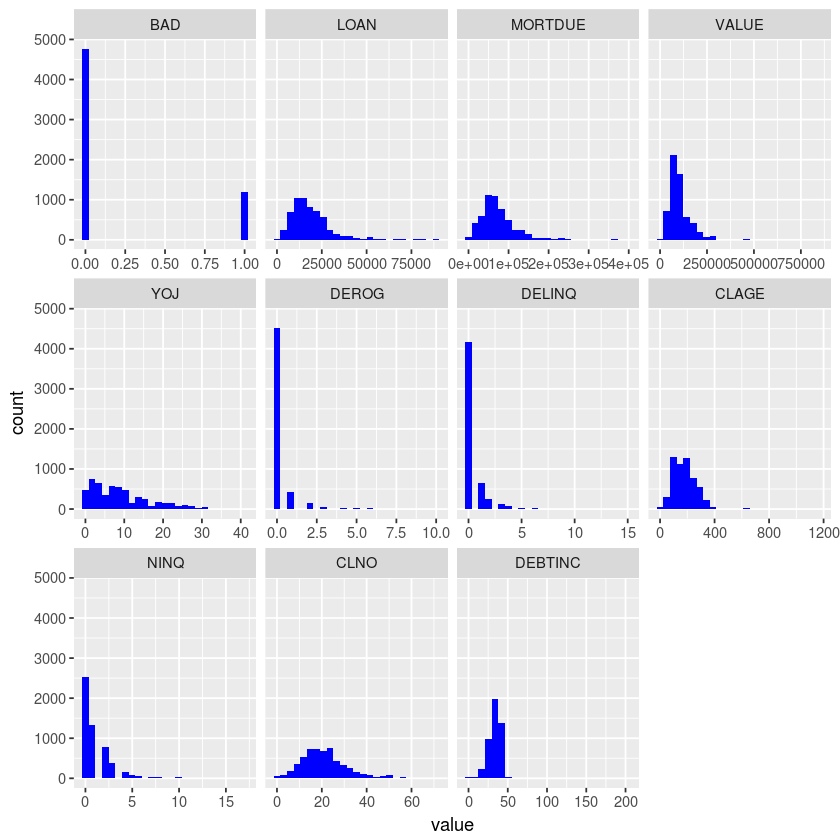

In [7]:
# Bring data locally
df <- to.casDataFrame(castbl, obs = nrow(castbl))
# Use reshape2's melt to help with data formatting
d <- melt(df[sapply(df, is.numeric)], id.vars=NULL)
ggplot(d, aes(x = value)) +
    facet_wrap(~variable,scales = 'free_x') +
    geom_histogram(fill = 'blue', bins = 25)

## Count Missing Values

In [8]:
# Get the number of missing values for all variables
tbl <- cas.simple.distinct(castbl)$Distinct[,c('Column', 'NMiss')]
tbl

Column,NMiss
BAD,0
LOAN,0
MORTDUE,518
VALUE,112
REASON,252
JOB,279
YOJ,515
DEROG,708
DELINQ,580
CLAGE,308


In [9]:
# Easy way to get missing values for numeric variables
cas.nmiss(castbl)

BAD    LOAN MORTDUE   VALUE     YOJ   DEROG  DELINQ   CLAGE    NINQ    CLNO 
      0       0     518     112     515     708     580     308     510     222 
DEBTINC 
   1267

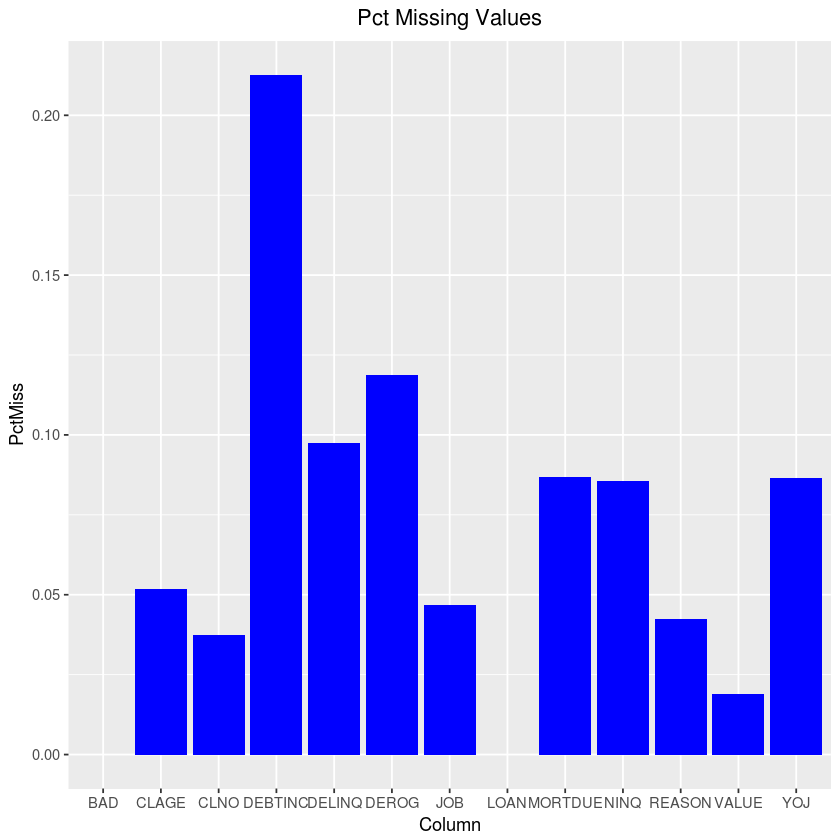

In [10]:
# Visualize the missing data
tbl$PctMiss <- tbl$NMiss/nrow(castbl)
ggplot(tbl, aes(Column, PctMiss)) +
    geom_col(fill = 'blue') +
    ggtitle('Pct Missing Values') +
    theme(plot.title = element_text(hjust = 0.5))

# Impute Missing Values

In [11]:
# Impute missing values
cas.dataPreprocess.impute(castbl,
    methodContinuous = 'MEDIAN',
    methodNominal = 'MODE',
    inputs = colnames(castbl)[-1],
    copyAllVars = TRUE,
    casOut = list(name = 'hmeq', 
                replace = TRUE)
)

Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
LOAN,Median,IMP_LOAN,5960,0,16300.00000,
MORTDUE,Median,IMP_MORTDUE,5442,518,65019.00000,
VALUE,Median,IMP_VALUE,5848,112,89235.50000,
REASON,Mode,IMP_REASON,5708,252,NaN,DebtCon
JOB,Mode,IMP_JOB,5681,279,NaN,Other
YOJ,Median,IMP_YOJ,5445,515,7.00000,
DEROG,Median,IMP_DEROG,5252,708,0.00000,
DELINQ,Median,IMP_DELINQ,5380,580,0.00000,
CLAGE,Median,IMP_CLAGE,5652,308,173.46667,
NINQ,Median,IMP_NINQ,5450,510,1.00000,


# Partition the data into Training and Validation

In [12]:
# Partition the data
cas.sampling.srs(conn,
    table = 'hmeq',
    samppct = 30,
    partind = TRUE,
    output = list(casOut = list(name = 'hmeq', replace = T), copyVars = 'ALL')
)

$outputSize
$outputSize$outputNObs
[1] 5960

$outputSize$outputNVars
[1] 26


$SRSFreq
  NObs NSamp
1 5960  1788

$OutputCasTables
             casLib Name Label Rows Columns
1 CASUSER(viyauser) hmeq       5960      26

# Variable Mapping
Define varibles with generic labels and reuse between model calls

In [13]:
#Note: I do not want to hard code any of my variable names.
indata <- 'hmeq'

# Get variable info and types
colinfo <- head(cas.table.columnInfo(conn, table = indata)$ColumnInfo, -1)

# My target variable is the first column
target <- colinfo$Column[1]

# For models that can inherently handle missing values (ex: Decision Tree)
inputs <- colinfo$Column[-1]
nominals <- c(target, subset(colinfo, Type == 'varchar')$Column)

# For models that cannot handle missing values (ex: Neural Network)
imp.inputs <- grep('IMP_', inputs, value = T)
imp.nominals <- c(target, grep('IMP_', nominals, value = T))

# Build Models

## Decision Tree

In [14]:
cas.decisionTree.dtreeTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    varImp = TRUE,
    casOut = list(name = 'dt_model', replace = TRUE)
)

Descr,Value
Number of Tree Nodes,15.00000
Max Number of Branches,2.00000
Number of Levels,6.00000
Number of Leaves,8.00000
Number of Bins,20.00000
Minimum Size of Leaves,5.00000
Maximum Size of Leaves,3208.00000
Number of Variables,24.00000
Confidence Level for Pruning,0.25000
Number of Observations Used,4172.00000


## Forest

In [15]:
# Train the forest model
cas.decisionTree.forestTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    casOut = list(name = 'rf_model', replace = TRUE)
)

Descr,Value
Number of Trees,50.00000
Number of Selected Variables (M),5.00000
Random Number Seed,0.00000
Bootstrap Percentage (%),63.21206
Number of Bins,20.00000
Number of Variables,24.00000
Confidence Level for Pruning,0.25000
Max Number of Tree Nodes,29.00000
Min Number of Tree Nodes,11.00000
Max Number of Branches,2.00000


## Gradient Boosting

In [16]:
cas.decisionTree.gbtreeTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    casOut = list(name = 'gbt_model', replace = TRUE)
)

Descr,Value
Number of Trees,50.0
Distribution,2.0
Learning Rate,0.1
Subsampling Rate,0.5
Number of Selected Variables (M),24.0
Number of Bins,20.0
Number of Variables,24.0
Max Number of Tree Nodes,63.0
Min Number of Tree Nodes,17.0
Max Number of Branches,2.0


## Neural Network

In [17]:
cas.neuralNet.annTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = imp.inputs,
    nominals = imp.nominals,
    casOut = list(name = 'nn_model', replace = TRUE)
)

Progress,Objective,Loss
1,3.207240,3.207240
2,2.083080,2.083080
3,1.659620,1.659620
4,1.602940,1.602940
5,1.584095,1.584095
6,1.580721,1.580721
7,1.577360,1.577360
8,1.573985,1.573985
9,1.572499,1.572499
10,1.571956,1.571956


# Score the Models

In [18]:
models <- c('dt','rf','gbt','nn')
scores <- c(cas.decisionTree.dtreeScore, cas.decisionTree.forestScore, 
            cas.decisionTree.gbtreeScore, cas.neuralNet.annScore)
names(scores) <- models

# Function to help automate prediction process on new data
score.params <- function(model){return(list(
    object       = defCasTable(conn, indata),
    modelTable   = list(name = paste0(model, '_model')),
    copyVars     = list(target, '_PartInd_'),
    assessonerow = TRUE,
    casOut       = list(name = paste0(model, '_scored'), replace = T)
))}
lapply(models, function(x) {do.call(scores[[x]], score.params(x))})

[[1]]
[[1]]$OutputCasTables
             casLib      Name Rows Columns
1 CASUSER(viyauser) dt_scored 5960      16

[[1]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                      13.89261745


[[2]]
[[2]]$OutputCasTables
             casLib      Name Rows Columns
1 CASUSER(viyauser) rf_scored 5960       9

[[2]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                     17.197986577


[[3]]
[[3]]$OutputCasTables
             casLib       Name Rows Columns
1 CASUSER(viyauser) gbt_scored 5960       8

[[3]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                     7.3825503356

[[3]]$ErrorMetricInfo
   TreeID Trees NLeaves        MCR   LogLoss        ASE      RASE     MAXAE
1       0     1      20 0.19949664 0.4582469 0.14520421 0.3810567 0.8180418
2       1     2      42 0.19949664 0.4278157 0.13365810 0.3655928 0.8301853
3       2     3      66 0.19949664 0.4037130 0.12399244 0.3521256 0.8386586
4       3     4      91 0.19681208 0.3854042 0.11678392 0.3417366 0.8502550
5       4     5     115 0.17013423 0.3696944 0.11056527 0.3325136 0.8627706
6       5     6     138 0.14865772 0.3565601 0.10540768 0.3246655 0.8712547
7       6     7     164 0.13087248 0.3432295 0.10032596 0.3167427 0.8811061
8       7     8     194 0.12265101 0.3317898 0.09626432 0.3102649 0.8900111
9       8     9     221 0.11812081 0.3230588 0.09317000 0.3052376 0.8970049
10      9    10     248 0.11543624 0.3145563 0.09029587 0.3004927 0.9054190
11     10    11     277 0.11073826 0.3076774 0.08796324 0.2965860 0.9127927
12     11    12     301 0.10620805 0.3012515 0.08584227 0.2929885 0.9186322
13     12    13     331 0.10318792 0.2946904 0.08380280 0.2894871 0.9235057
14     13    14     354 0.10184564 0.2895462 0.08230635 0.2868908 0.9300829
15     14    15     382 0.10184564 0.2853263 0.08117847 0.2849184 0.9352239
16     15    16     405 0.09966443 0.2803013 0.07953468 0.2820189 0.9389340
17     16    17     434 0.09798658 0.2757884 0.07832599 0.2798678 0.9435977
18     17    18     463 0.09748322 0.2710652 0.07684023 0.2772007 0.9452424
19     18    19     494 0.09949664 0.2663138 0.07550419 0.2747802 0.9479941
20     19    20     516 0.09781879 0.2633856 0.07476513 0.2734321 0.9509509
21     20    21     542 0.09781879 0.2602952 0.07400474 0.2720381 0.9551982
22     21    22     565 0.09614094 0.2576103 0.07328185 0.2707062 0.9581418
23     22    23     592 0.09345638 0.2540839 0.07224381 0.2687821 0.9601847
24     23    24     611 0.09312081 0.2512952 0.07138712 0.2671837 0.9633929
25     24    25     641 0.09194631 0.2485761 0.07069345 0.2658824 0.9670457
26     25    26     670 0.09211409 0.2458380 0.07008537 0.2647364 0.9694544
27     26    27     698 0.09278523 0.2430392 0.06929895 0.2632469 0.9708386
28     27    28     725 0.09144295 0.2406452 0.06859903 0.2619142 0.9666168
29     28    29     757 0.09093960 0.2373479 0.06762814 0.2600541 0.9660596
30     29    30     781 0.08926174 0.2352226 0.06698806 0.2588205 0.9665679
31     30    31     806 0.08892617 0.2328483 0.06631687 0.2575206 0.9688589
32     31    32     830 0.08724832 0.2302107 0.06549294 0.2559159 0.9697010
33     32    33     850 0.08590604 0.2289139 0.06518489 0.2553133 0.9724792
34     33    34     868 0.08607383 0.2270033 0.06469983 0.2543616 0.9689822
35     34    35     896 0.08439597 0.2245779 0.06384197 0.2526697 0.9702996
36     35    36     925 0.08372483 0.2211489 0.06289248 0.2507837 0.9716604
37     36 

# Assess Models

## Confusion Matrix

In [19]:
# Load the percentile actionset for scoring
loadActionSet(conn, 'percentile')

# Useful function for model assessment
assess.model <- function(model){
    cas.percentile.assess(conn,
        table    = list(name = paste0(model,'_scored'), 
                        where = '_PartInd_ = 1'),
        inputs   = paste0('_', model, '_P_           1'),
        response = target,
        event    = '1')
}

model.names <- c('Decision Tree', 'Random Forest', 
                 'Gradient Boosting', 'Neural Network')
roc.df <- data.frame()
for (i in 1:length(models)){
    tmp <- (assess.model(models[i]))$ROCInfo
    tmp$Model <- model.names[i] 
    roc.df <- rbind(roc.df, tmp)
}

# Manipulate the dataframe
compare <- subset(roc.df, round(roc.df$CutOff, 2) == 0.5)
rownames(compare) <- NULL
compare[,c('Model','TP','FP','FN','TN')]

Model,TP,FP,FN,TN
Decision Tree,260,147,89,1292
Random Forest,52,2,297,1437
Gradient Boosting,240,49,109,1390
Neural Network,127,41,222,1398


## Misclassification

In [20]:
# Build a dataframe to compare the misclassification rates
compare$Misclassification <- 1 - compare$ACC
miss <- compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) <- NULL
miss

Model,Misclassification
Gradient Boosting,0.08836689
Decision Tree,0.13199105
Neural Network,0.14709172
Random Forest,0.16722595


## ROC

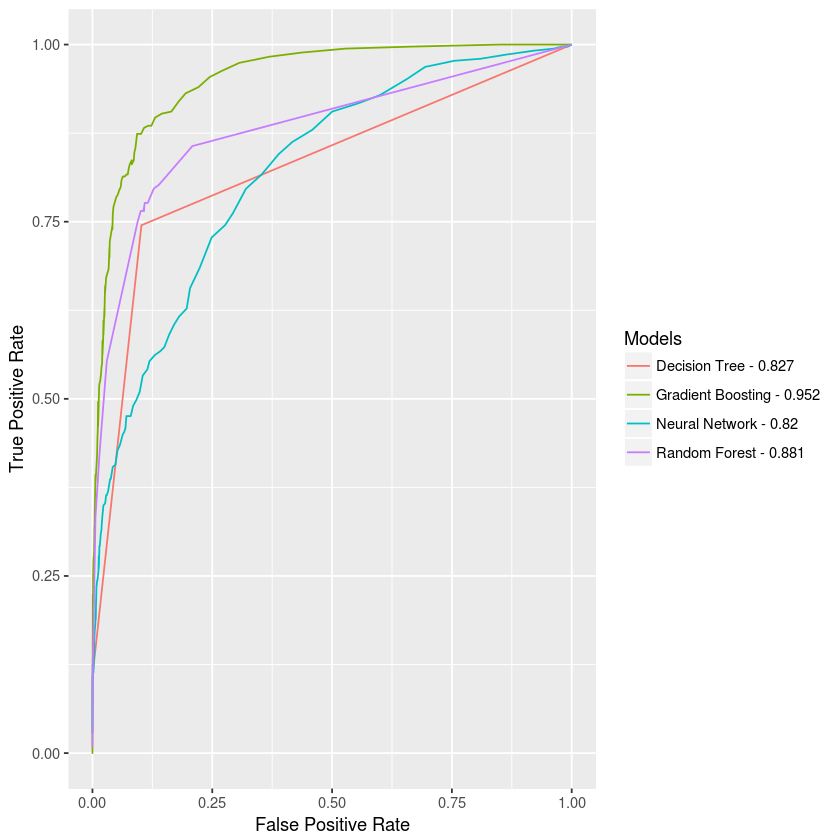

In [21]:
# Add a new column to be used as the ROC curve label
roc.df$Models <- paste(roc.df$Model, round(roc.df$C, 3), sep = ' - ')

# Create the ROC curve
ggplot(data = roc.df[c('FPR', 'Sensitivity', 'Models')],
    aes(x = as.numeric(FPR), y = as.numeric(Sensitivity), colour = Models)) +
    geom_line() +
    labs(x = 'False Positive Rate', y = 'True Positive Rate')

## End the session

In [22]:
# End the session
cas.session.endSession(conn)

list()